<a href="https://colab.research.google.com/github/codebybishwa/Differential-Privacy-Preserving-Facial-Recognition/blob/main/Differential_Privacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Data Collection**
   (The CelebA dataset is a good choice because it contains over 200,000 celebrity images with rich attribute annotations, allowing us to consider diversity in demographics.)


In [2]:
import os
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

Files already downloaded and verified


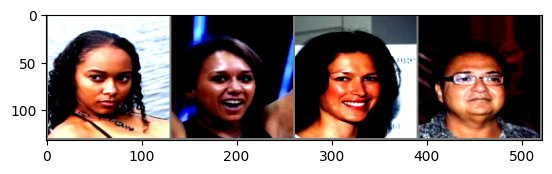

In [3]:
# Define the data transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Loading the CelebA dataset
dataset = datasets.CelebA(root='data', split='train', download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Checking the dataset
data_iter = iter(dataloader)
images, labels = next(data_iter)

# Displaying some images
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images[:4]))

### **Model Development**
We'll build a simple CNN model using PyTorch as a baseline for facial recognition.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(64 * 30 * 30, 128)
        self.fc2 = nn.Linear(128, 40)  # CelebA has 40 binary attribute labels

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 64 * 30 * 30)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy for multi-label classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [5]:
!pip install opacus

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from opacus import PrivacyEngine
from torch.utils.data import DataLoader, Subset  # Make sure to import Subset

# Use a smaller dataset for quicker testing
small_dataset = Subset(dataset, range(0, 1000))
dataloader = DataLoader(small_dataset, batch_size=16, shuffle=True, num_workers=4)

# Initializing the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Integrating Differential Privacy using Opacus
privacy_engine = PrivacyEngine()
model, optimizer, dataloader = privacy_engine.make_private(
    module=model,
    optimizer=optimizer,
    data_loader=dataloader,
    noise_multiplier=0.5,  # Adjusted for faster training
    max_grad_norm=0.5,  # Adjusted for faster training
)

# Training loop with fewer epochs
for epoch in range(3):  # Fewer epochs to test the setup
    for data, target in dataloader:
        optimizer.zero_grad()

        target = target.float()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

torch.save(model.state_dict(), 'facial_recognition_model.pth')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in fu

Epoch 1, Loss: 0.42923232913017273
Epoch 2, Loss: 0.47497889399528503
Epoch 3, Loss: 0.45667392015457153


### **Fairness Analysis**
We’ll evaluate the model’s fairness by checking for bias across different demographic groups.

In [7]:
from sklearn.metrics import accuracy_score
import numpy as np

# Evaluating the model's accuracy across different demographic groups

def evaluate_fairness(model, dataloader, demographic_labels):
    accuracies = {}
    for demographic in demographic_labels:
        correct = 0
        total = 0
        for data, labels in dataloader:
            outputs = model(data)
            predicted = torch.round(torch.sigmoid(outputs))
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        accuracy = 100 * correct / total
        accuracies[demographic] = accuracy
    return accuracies

# Example usage
demographic_labels = ['Male', 'Female', 'Young', 'Old']  # Hypothetical groups
fairness_metrics = evaluate_fairness(model, dataloader, demographic_labels)
print(fairness_metrics)

{'Male': 3240.390243902439, 'Female': 3237.8159757330636, 'Young': 3243.3, 'Old': 3238.673469387755}


In [19]:
!pip install flask-ngrok
!pip install flask